In [1]:
import glob
import io
import math
import os
import scipy

from __future__ import print_function
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/home/arina/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv(
    io.open("/home/arina/Kenji_proj/Kinase/fullTab_desc_HRinter_solvEn.corr.3.tab", "r"), sep="\t")

np.random.seed(4)
df = df.reindex(np.random.permutation(df.index))
names = df['Compl']
df = df.drop('Compl',axis=1)

In [3]:
df

,Comp,minimizedAffinity,ICM_hbonds,ICM_area,gauss_o0_w0_5_c8_,repulsion_o0_c8_,hydrophobic_g0_5_b1_5_c8_,non_hydrophobic_g0_5_b1_5_c8_,vdw_i6_j12_s1_100_c8_,non_dir_h_bond_lj_o_0_7_100_c8_,...,TOTAL_SOLV,POLAR_SOLV,NONPOLAR_SOLV,COULOMB,prTar,APF_score,Seq,APF_sim,Seq_distance,activ
3579,v103904595,-8.4,0,329.5,87.8,2.4,37.7,89.0,-643.2,-22.4,...,-20.7,-24.1,3.4,-1279.9,4KWP,-288.3,43.1,0.4,1.0,7.6
8674,v103904906,-9.8,1,248.4,76.7,1.4,50.0,40.5,-487.8,-12.9,...,-11.8,-14.6,2.8,-76.5,4YMJ,-306.0,71.9,0.3,0.9,5.7
16717,v103904212,-7.8,2,289.6,78.5,2.3,46.2,35.8,-520.6,-9.4,...,-16.3,-18.8,2.5,-749.7,4USF,-242.1,34.3,0.1,1.0,5.4
4392,v103904729,-9.3,1,277.7,86.4,1.6,46.5,62.2,-521.4,-21.7,...,-18.0,-20.7,2.6,-524.4,3BHY,-213.6,93.7,0.1,0.9,6.1
19851,v103904331,-9.8,0,320.0,78.4,1.2,29.8,68.2,-644.4,-14.0,...,-26.1,-29.6,3.5,-1176.0,5G1X,-554.1,266.6,1.0,0.0,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,v103904773,-8.9,1,376.7,100.6,2.9,38.4,74.1,-722.7,-11.7,...,-15.5,-19.2,3.7,-922.2,4TWC,-672.4,306.8,1.0,0.0,8.1
11863,v103904354,-9.3,1,321.7,80.3,1.4,39.4,60.4,-655.0,-11.1,...,-23.7,-27.9,4.2,-944.2,3HNG,-283.9,116.3,0.2,0.9,6.8
17093,v103904329,-8.9,2,241.0,57.5,0.5,44.6,38.5,-493.7,-7.1,...,-22.3,-25.5,3.2,-1040.4,4RT7,-330.5,55.3,0.3,1.0,6.1
8366,v103904458,-9.1,0,338.3,104.4,4.4,86.2,28.4,-683.3,-1.6,...,-22.7,-25.8,3.1,-646.6,4IVA,-243.8,46.2,0.1,1.0,6.8


In [4]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [5]:
for var in ['minimizedAffinity','nof_Atoms',
            'vdw_i6_j12_s1_100_c8_','non_dir_h_bond_lj_o_0_7_100_c8_',
            'repulsion_o0_c8_','non_dir_h_bond_g_0_7_b0_c8_',
            'electrostatic_i2_100_c8_','H_bond','donor_donor_quadratic_o0_c8_',
            'non_dir_anti_h_bond_quadratic_o0_c8_','acceptor_acceptor_quadratic_o0_c8_',
            'ad4_solvation_d_sigma3_6_s_q0_01097_c8_','sc1','sc2','sc3',
            'Hal_bond','Salt_Bridges','pi_Cation','pi_Stacking',
            'scCons','xEnergy','ICM_hbonds','ICM_area','gauss_o0_w0_5_c8_',
            'hydrophobic_g0_5_b1_5_c8_','non_hydrophobic_g0_5_b1_5_c8_',
            'gauss_o3_w2_c8_','TOTAL_EELEC','TOTAL_SOLV', 'POLAR_SOLV', 
            'NONPOLAR_SOLV','COULOMB']:
    df[var] = z_score_normalize(df[var])
    

In [6]:
df = df.drop(['prTar','Seq_distance','Seq','APF_score','APF_sim'], axis=1)

cat_features=df[['Tar','HR_1','HR_2','HR_3']]
num_features=df.drop(cat_features, axis=1)
num_features=num_features.drop('Comp', axis=1)
all_feat=df.drop(['activ','Comp'],axis=1)

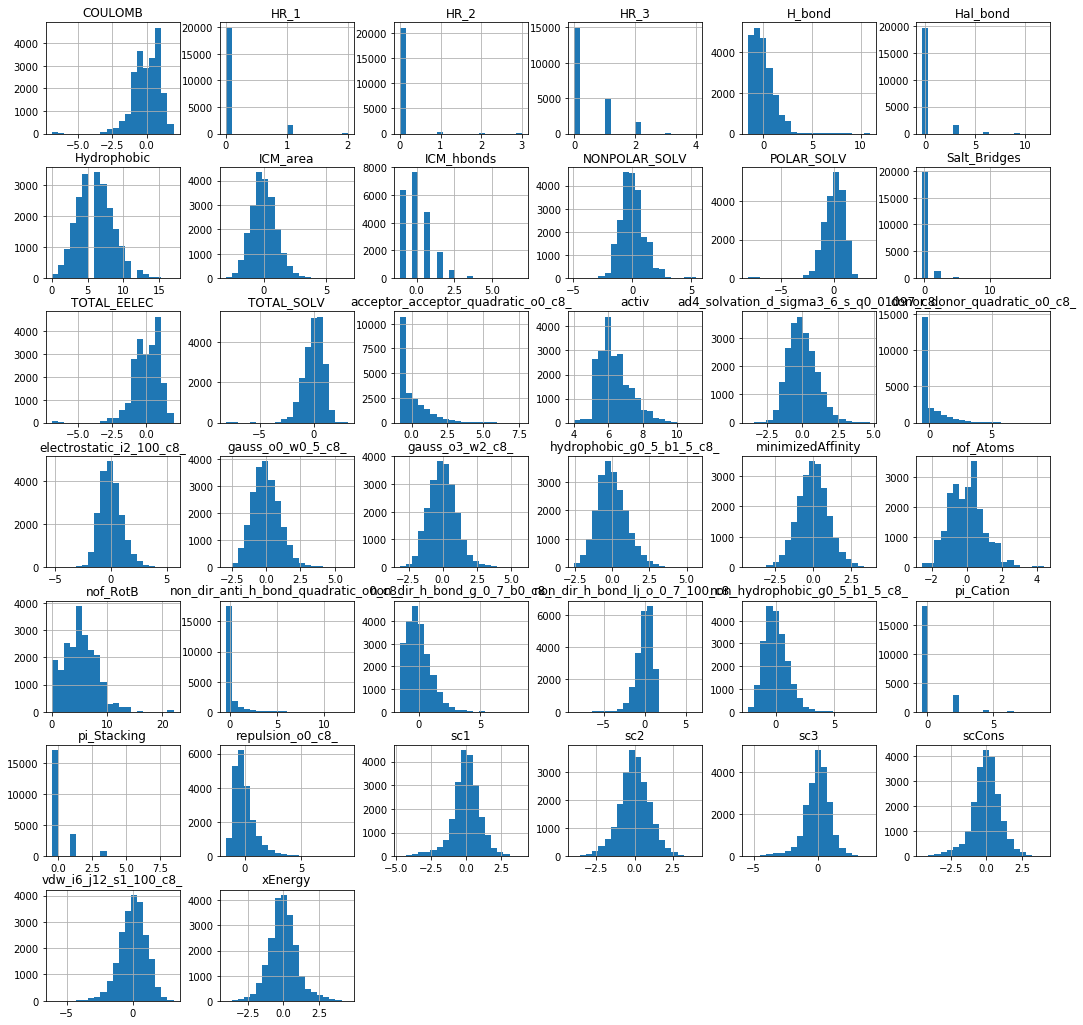

In [7]:
_ = df.hist(bins=20, figsize=(18, 18), xlabelsize=10)

In [8]:
for feat in cat_features:
    df[feat] = pd.Categorical(df[feat])
    dfDummies = pd.get_dummies(df[feat], prefix = 'cat_'+str(feat))
    df = pd.concat([df, dfDummies], axis=1)
    df = df.drop(feat, axis=1)

In [9]:
testComp=['v103905639','v103905539','v103905616','v103905521','v103905590','v103905503','v103904865','v103905107','v103905657','v103904504','v103905622','v103904925','v103904871','v103905673','v103905378']
testSet=df[df.Comp.isin(testComp)]
df=df[-df.Comp.isin(testComp)]
dfCompNames=df.Comp
testCompNames=testSet.Comp
df = df.drop('Comp',axis=1)
testSet = testSet.drop('Comp',axis=1)

y_train = df['activ'][:16000]
x_train = df.drop("activ", axis=1)[:16000]
y_test = df['activ'][16000:]
x_test = df.drop("activ", axis=1)[16000:]
y_testComp = testSet['activ'][:]
x_testComp = testSet.drop("activ", axis=1)[:]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_testComp.shape[0], 'test excluded compounds')


x_train shape: (16000, 150)
16000 train samples
5047 test samples
435 test excluded compounds


In [10]:
input_shape=(x_train.shape[1],)
input_shape

(150,)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
best_mod = ModelCheckpoint('DNN-altModel-best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
reg=0.00001
reg1=0.00001
drop=0.3

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=input_shape,
                kernel_regularizer=regularizers.l2(reg),
                activity_regularizer=regularizers.l1(reg1)))
model.add(Dropout(drop))
model.add(Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(reg),
                activity_regularizer=regularizers.l1(reg1)))
model.add(Dropout(drop))
model.add(Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(reg),
                activity_regularizer=regularizers.l1(reg1)))
model.add(Dropout(drop))
model.add(Dense(1, activation='relu'))


In [12]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])


In [13]:
batch_size = 10
epochs = 100

In [14]:
model1 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stop, best_mod])

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 16000 samples, validate on 5047 samples
Epoch 1/100
16000/16000 [==============================] - 26s 2ms/step - loss: 1.7277 - mean_squared_error: 1.6856 - val_loss: 0.9878 - val_mean_squared_error: 0.9496

Epoch 00001: val_loss improved from inf to 0.98779, saving model to DNN-altModel-best.h5
Epoch 2/100
16000/16000 [==============================] - 12s 762us/step - loss: 1.0486 - mean_squared_error: 1.0155 - val_loss: 0.7067 - val_mean_squared_error: 0.6797

Epoch 00002: val_loss improved from 0.98779 to 0.70671, saving model to DNN-altModel-best.h5
Epoch 3/100
16000/16000 [==============================] - 12s 742us/step - loss: 0.7979 - mean_squared_error: 0.7727 - val_loss: 0.7093 - val_mean_squared_error: 0.6851

Epoch 00003: val_loss did not improve
Epoch 4/100
16000/16000 [==============================] - 12s 747us/step - loss: 0.7836 - mean_squared_error: 0.7588 - val_loss: 0.6684 - val_mean_squared_error: 0.6434

Epoch 00004: val_loss improved from 0.70671 to 0.

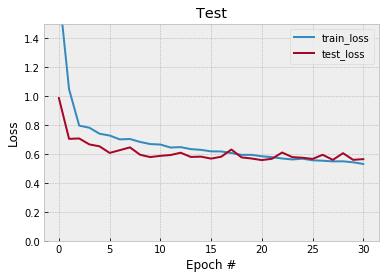

In [15]:
H = model1.history

N = np.arange(0, len(H["loss"]))

plt.style.use("bmh")
plt.figure()
plt.plot(N, H["loss"], label="train_loss")
plt.plot(N, H["val_loss"], label="test_loss")
plt.title("Test")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylim((0,1.5))
plt.legend()



In [16]:
model.load_weights("DNN-altModel-best.h5")


In [17]:
import scipy.stats
tr_prediction = model.predict(np.array(x_train))
tr_prediction = np.squeeze(tr_prediction, axis=(1,))
y_train=np.array(y_train)

print(scipy.stats.pearsonr(tr_prediction, y_train) )

(0.707758333269218, 0.0)


In [18]:
import scipy.stats
val_prediction = model.predict(np.array(x_test))
val_prediction = np.squeeze(val_prediction, axis=(1,))
y_test=np.array(y_test)

print(scipy.stats.pearsonr(val_prediction, y_test) )

(0.6070731984340552, 0.0)


In [19]:
test_prediction = model.predict(np.array(x_testComp))
test_prediction = np.squeeze(test_prediction, axis=(1,))
y_testComp=np.array(y_testComp)

print(scipy.stats.pearsonr(test_prediction, y_testComp) )

(-0.01783975825201804, 0.7106102842912914)


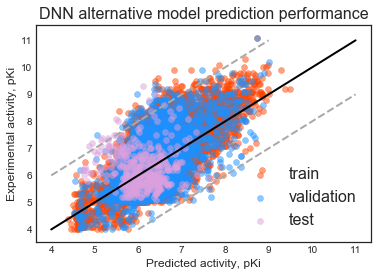

In [20]:
plt.style.use("seaborn-white")
plt.scatter(tr_prediction, y_train, alpha=0.5, color='orangered', label='train')
plt.scatter(val_prediction, y_test, alpha=0.5, color='dodgerblue',label='validation')
plt.scatter(test_prediction, y_testComp, alpha=0.5, color='plum', label='test')
plt.plot([4,11], [4,11], c='black')
plt.plot([6,11], [4,9], c='darkgrey', ls='dashed')
plt.plot([4,9], [6,11], c='darkgrey', ls='dashed')
plt.legend(loc='lower right', fontsize=16)
plt.title("DNN alternative model prediction performance", fontsize=16)
plt.xlabel("Predicted activity, pKi")
plt.ylabel("Experimental activity, pKi")
plt.show()

In [21]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [22]:
rmse(tr_prediction, y_train)

0.6571053106454476

In [23]:
rmse(val_prediction, y_test)

0.7299056964742443

In [24]:
rmse(test_prediction, y_testComp)

0.8645830021667812

In [25]:
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm.libsvm import cross_validation
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=300)
rf = rf.fit(x_train,y_train)

scores = cross_val_score(rf, x_train,y_train, cv=3, n_jobs=-1)
print("accuracies     = ",scores)
print("mean accuracy = %4.2f" % (scores.mean()))


accuracies     =  [0.35307373 0.35697499 0.32449908]
mean accuracy = 0.34


In [26]:
tr_prediction_rf = rf.predict(np.array(x_train))
y_train=np.array(y_train)

print(scipy.stats.pearsonr(tr_prediction_rf, y_train) )

(0.9780353224103947, 0.0)


In [27]:
val_prediction_rf = rf.predict(np.array(x_test))
y_test=np.array(y_test)

print(scipy.stats.pearsonr(val_prediction_rf, y_test) )

(0.6300024026822382, 0.0)


In [28]:
test_prediction_rf = rf.predict(np.array(x_testComp))
y_testComp=np.array(y_testComp)

print(scipy.stats.pearsonr(test_prediction_rf, y_testComp) )

(0.10228032288686935, 0.03295073787127151)


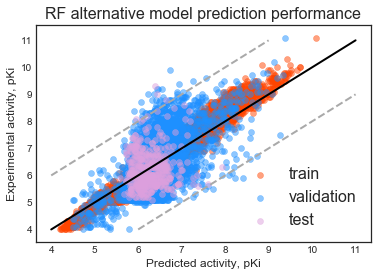

In [29]:
plt.style.use("seaborn-white")
plt.scatter(tr_prediction_rf, y_train, alpha=0.5, color='orangered', label='train')
plt.scatter(val_prediction_rf, y_test, alpha=0.5, color='dodgerblue',label='validation')
plt.scatter(test_prediction_rf, y_testComp, alpha=0.5, color='plum', label='test')
plt.plot([4,11], [4,11], c='black')
plt.plot([6,11], [4,9], c='darkgrey', ls='dashed')
plt.plot([4,9], [6,11], c='darkgrey', ls='dashed')
plt.legend(loc='lower right', fontsize=16)
plt.title("RF alternative model prediction performance", fontsize=16)
plt.xlabel("Predicted activity, pKi")
plt.ylabel("Experimental activity, pKi")
plt.show()


In [30]:
rmse(tr_prediction_rf, y_train)

0.2674384866448524

In [31]:
rmse(val_prediction_rf, y_test)

0.7156654619213161

In [32]:
rmse(test_prediction_rf, y_testComp)

0.7473115359746336

In [33]:
from sklearn.externals import joblib
joblib.dump(rf, 'RF_altModel.pkl') 

['RF_altModel.pkl']

In [34]:
model_json = model.to_json()
with open("DNN_altModel.json", "w") as json_file:
    json_file.write(model_json)